In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import defaultdict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from Bio import Align
from Bio.Align import substitution_matrices
import networkx as nx
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import StackingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


In [2]:
def parse_optuna_log(file_path):
    trial_pattern = re.compile(r"\[I \d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}] Trial (\d+) finished with value: ([0-9.]+) and parameters: ({.*}). Best is trial (\d+) with value: ([0-9.]+).")
    trials = {}

    with open(file_path, 'r') as file:
        for line in file:
            match = trial_pattern.search(line)
            if match:
                trial_number = int(match.group(1))
                trial_value = match.group(2)
                parameters = match.group(3)
                best_trial_number = int(match.group(4))
                best_trial_value = match.group(5)

                # Store all trials with their details
                trials[trial_number] = {
                    'value': trial_value,
                    'parameters': parameters
                }

                # Check if this is trial 199
                if trial_number == 199:
                    if best_trial_number in trials:
                        print(f"File: {file_path}")
                        print(f"Trial 199 Best Trial: {best_trial_number}")
                        print(f"Best Trial Score: {best_trial_value}")
                        print(f"Best Trial Parameters: {trials[best_trial_number]['parameters']}\n")


In [3]:
# Loop through each file in the directory
for filename in os.listdir('Optuna/'):
    if filename.endswith(".log"):  # Assuming your log files have a .log extension
        file_path = os.path.join('Optuna/', filename)
        parse_optuna_log(file_path)

File: Optuna/optimization_anchor_dl.log
Trial 199 Best Trial: 193
Best Trial Score: 0.7482677091363963
Best Trial Parameters: {'n_estimators': 614, 'max_depth': 3, 'learning_rate': 0.0031547499468758847, 'subsample': 0.5077304183730142, 'colsample_bytree': 0.9385666674404126, 'min_child_weight': 7, 'gamma': 5.26142016322878e-07, 'alpha': 0.01761048606321779, 'lambda': 0.00017921334871095828, 'scale_pos_weight': 5.810470560648237}

File: Optuna/optimization_anchor_dl.log
Trial 199 Best Trial: 19
Best Trial Score: 0.698782460076577
Best Trial Parameters: {'epochs': 32, 'batch_size': 43, 'units1': 58, 'dropout1': 0.2554839135552426, 'units2': 85, 'dropout2': 0.4969120304561664, 'lr': 0.00014038195336976152}

File: Optuna/optimization_anchor_dl.log
Trial 199 Best Trial: 156
Best Trial Score: 0.6944809282476073
Best Trial Parameters: {'n_estimators': 939, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'bootstrap': True, 'c

In [4]:
xgb_params_dl = {'n_estimators': 614, 'max_depth': 3, 'learning_rate': 0.0031547499468758847, 'subsample': 0.5077304183730142, 'colsample_bytree': 0.9385666674404126, 'min_child_weight': 7, 'gamma': 5.26142016322878e-07, 'alpha': 0.01761048606321779, 'lambda': 0.00017921334871095828, 'scale_pos_weight': 5.810470560648237}
nn_params_dl = {'epochs': 32, 'batch_size': 43, 'units1': 58, 'dropout1': 0.2554839135552426, 'units2': 85, 'dropout2': 0.4969120304561664, 'lr': 0.00014038195336976152}
rf_params_dl = {'n_estimators': 939, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced', 'bootstrap': True, 'criterion': 'gini', 'min_impurity_decrease': 0.09348407180818157}
svm_params_dl = {'C': 0.019936823798295568, 'kernel': 'poly', 'class_weight': 'balanced', 'shrinking': False, 'probability': True, 'degree': 2, 'gamma': 0.013580250860915737}
lr_params_dl = {'penalty': 'elasticnet', 'C': 0.0008090599535912034, 'class_weight': 'balanced', 'max_iter': 10000, 'l1_ratio': 0.8191089275357987}
lrrf_params_dl = {'lr_penalty': 'l1', 'solver_l1': 'saga', 'lr_C': 0.005588598678096986, 'lr_class_weight': 'balanced', 'lr_max_iter': 10000, 'rf_n_estimators': 509, 'rf_max_depth': 20, 'rf_min_samples_split': 18, 'rf_min_samples_leaf': 4, 'rf_max_features': 0.7, 'rf_class_weight': None, 'rf_bootstrap': True, 'rf_criterion': 'gini', 'rf_min_impurity_decrease': 0.0051017451509091085}
lrxgb_params_dl = {'lr_penalty': 'elasticnet', 'lr_C': 0.008009598742391159, 'lr_class_weight': 'balanced', 'lr_max_iter': 10000, 'lr_l1_ratio': 0.9538958186299081, 'n_estimators': 1295, 'max_depth': 15, 'learning_rate': 0.002791466856518535, 'subsample': 0.6984064407055942, 'colsample_bytree': 0.6605994541389321, 'min_child_weight': 3, 'gamma': 0.24615479427756454, 'alpha': 0.2403868813579456, 'lambda': 0.0001494842560208305, 'scale_pos_weight': 6.355053663937669}

xgb_params_ndl = {'n_estimators': 496, 'max_depth': 11, 'learning_rate': 0.06800146575431848, 'subsample': 0.6778707905519383, 'colsample_bytree': 0.8816376441418772, 'min_child_weight': 9, 'gamma': 0.005666690400782176, 'alpha': 0.43742914810730277, 'lambda': 7.596918154081396e-07, 'scale_pos_weight': 6.937092771199039}
nn_params_ndl = {'epochs': 38, 'batch_size': 59, 'units1': 60, 'dropout1': 0.3989443531338258, 'units2': 80, 'dropout2': 0.4381150477174752, 'lr': 8.704567341900082e-05}
rf_params_ndl = {'n_estimators': 532, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'class_weight': 'balanced_subsample', 'bootstrap': True, 'criterion': 'entropy', 'min_impurity_decrease': 0.003858296606664444}
svm_params_ndl = {'C': 1.0311115568670572, 'kernel': 'sigmoid', 'class_weight': 'balanced', 'shrinking': True, 'probability': False, 'gamma': 0.005039741794420312}
lr_params_ndl = {'penalty': 'l2', 'solver_l2': 'saga', 'C': 1.2707787011744711e-05, 'class_weight': 'balanced', 'max_iter': 10000}
lrrf_params_ndl = {'lr_penalty': None, 'solver_none': 'newton-cg', 'lr_C': 0.7525810418645972, 'lr_class_weight': None, 'lr_max_iter': 10000, 'rf_n_estimators': 959, 'rf_max_depth': 22, 'rf_min_samples_split': 12, 'rf_min_samples_leaf': 11, 'rf_max_features': 0.5, 'rf_class_weight': 'balanced_subsample', 'rf_bootstrap': True, 'rf_criterion': 'gini', 'rf_min_impurity_decrease': 0.0018262683802666617}
lrxgb_params_ndl = {'lr_penalty': 'elasticnet', 'lr_C': 0.0005333434271652176, 'lr_class_weight': 'balanced', 'lr_max_iter': 10000, 'lr_l1_ratio': 0.6698751664836847, 'n_estimators': 799, 'max_depth': 12, 'learning_rate': 0.0057748386064016295, 'subsample': 0.5123540897751612, 'colsample_bytree': 0.7565767226567882, 'min_child_weight': 10, 'gamma': 1.4203493587293287e-05, 'alpha': 0.791037665274758, 'lambda': 0.008049484672931165, 'scale_pos_weight': 3.9998995786053624}

In [5]:
def load_and_preprocess_data_ns(group):
    train_df = pd.read_csv(f'Performance_data/Anchor_long_new/{group}_exclude.csv')
    test_df = pd.read_csv(f'Performance_data/Anchor_long_new/{group}_include.csv')

    def prepare_data(df):
        #columns_to_drop = [col for col in df.columns if 'Residue' in col]
        #df = df.drop(columns=columns_to_drop)
        features = df.drop(columns=['Label', 'First Sequence', 'Second Sequence'])
        labels = df['Label']
        return df, features, labels

    train_df, X_train, y_train = prepare_data(train_df)
    test_df, X_test, y_test = prepare_data(test_df)

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['HLA Type'])
        ], remainder='passthrough')
    
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    return train_df, test_df, X_train_processed, X_test_processed, y_train, y_test

In [92]:
f1_scores = []
group_sizes = []

# Update the group names if needed
#groups = ['Group_1_3_4', 'Group_31', 'Group_33', 'Group_47', 'Group_Rest']
groups = ['Group_1_4_7_13', 'Group_30', 'Group_32', 'Group_47', 'Group_Rest']
#groups = ['Group_1_3', 'Group_30', 'Group_32', 'Group_47', 'Group_Rest']
# Iterate over each group in your dataset
for group in groups:
    train_df, test_df, X_train, X_test, y_train, y_test = load_and_preprocess_data_ns(group)
    
    # Initialize the model with the best parameters
    model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
        
    # Fit the model
    model.fit(X_train, y_train)
        
    # Predict the test set
    y_pred = model.predict(X_test)
        
    # Calculate the F1 score
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

    # Store the size of the group
    group_size = len(y_test)
    group_sizes.append(group_size)

    print(f"F1 Score for {group}: {f1} (Group size: {group_size})")

# Calculate the average F1 score across all groups, weighted by group size if necessary
avg_f1_score = sum(f1_scores) / len(f1_scores)
print(f"Average F1 Score across all groups: {avg_f1_score}")

# Optionally, calculate a weighted average if you want to account for group size differences
weighted_avg_f1_score = sum(f * s for f, s in zip(f1_scores, group_sizes)) / sum(group_sizes)
print(f"Weighted Average F1 Score across all groups: {weighted_avg_f1_score}")

F1 Score for Group_1_4_7_13: 0.5222222222222223 (Group size: 249)
F1 Score for Group_30: 0.9629629629629629 (Group size: 1595)
F1 Score for Group_32: 0.6947368421052632 (Group size: 1712)
F1 Score for Group_47: 0.9090909090909091 (Group size: 1528)
F1 Score for Group_Rest: 0.8161764705882353 (Group size: 203)
Average F1 Score across all groups: 0.7810378813939186
Weighted Average F1 Score across all groups: 0.8341447825919784


In [93]:
# Initialize lists to store all actual labels and predictions
all_labels = []
all_predictions = []

# Iterate over each group in your dataset
for group in groups:
    train_df, test_df, X_train, X_test, y_train, y_test = load_and_preprocess_data_ns(group)
    
    # Initialize the model with the best parameters
    model = XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict the test set
    y_pred = model.predict(X_test)
    
    # Store predictions and labels
    all_labels.extend(y_test)
    all_predictions.extend(y_pred)

# Calculate the overall F1 score from the aggregated data
overall_f1_score = f1_score(all_labels, all_predictions)
print(f"Overall F1 Score across all groups from aggregated data: {overall_f1_score}")

Overall F1 Score across all groups from aggregated data: 0.7328859060402685


In [96]:
df = pd.read_excel('features.xlsx')
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df.drop(columns=['Filename'])

In [97]:
def hamming_distance(s1, s2):
    """Calculate the Hamming distance between two strings."""
    if len(s1) != len(s2):
        raise ValueError("Strings must be of the same length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))


unique_sequences = df['First Sequence'].unique()

# Find similar sequences
similar_sequences = []
threshold = 2  # Max number of letter differences

for i in range(len(unique_sequences)):
    for j in range(i + 1, len(unique_sequences)):
        seq1 = unique_sequences[i]
        seq2 = unique_sequences[j]
        if hamming_distance(seq1, seq2) <= threshold:
            similar_sequences.append((seq1, seq2))

In [98]:
# Convert list of pairs into a graph using a dictionary
graph = defaultdict(set)
for seq1, seq2 in similar_sequences:
    graph[seq1].add(seq2)
    graph[seq2].add(seq1)

# Function to find connected components (groups of connected sequences)
def find_connected_components(graph):
    visited = set()
    def dfs(node, component):
        component.add(node)
        visited.add(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, component)
        return component
    
    components = []
    for node in graph:
        if node not in visited:
            components.append(dfs(node, set()))
    return components

# Find groups of similar sequences
sequence_groups = find_connected_components(graph)

# Add unique sequences that are not in any group as their own group
included_sequences = {seq for group in sequence_groups for seq in group}
all_sequences = set(unique_sequences)
unique_single_groups = [[seq] for seq in all_sequences if seq not in included_sequences]

# Append these single sequence groups to the main groups
sequence_groups.extend(unique_single_groups)

In [99]:
results = []  # This will store the results as a list of dictionaries for easy conversion to DataFrame later

# Assuming 'df' is your main DataFrame with all data
for i, group in enumerate(sequence_groups, 1):
    # Filter the DataFrame to only include rows where 'First Sequence' or 'Second Sequence' is in the current group
    filtered_df = df[df['First Sequence'].isin(group) | df['Second Sequence'].isin(group)]
    
    # Count the labels
    label_counts = filtered_df['Label'].value_counts().to_dict()
    
    # Store the result with the group information
    results.append({
        'Group ID': i,
        'Group Sequences': ', '.join(group),
        'Label 0 Count': label_counts.get(0, 0),  # Default to 0 if no rows with Label 0
        'Label 1 Count': label_counts.get(1, 0)  # Default to 0 if no rows with Label 1
    })

In [100]:
# Create a dictionary to map each sequence to its group ID
sequence_to_group_id = {}
for i, group in enumerate(sequence_groups, 1):
    for sequence in group:
        sequence_to_group_id[sequence] = i

# Map the 'First Sequence' in df to the new 'Group ID' column using the dictionary
df['Group ID'] = df['First Sequence'].map(sequence_to_group_id)

In [101]:
# One-hot encoding 'HLA Type'
encoder = OneHotEncoder(sparse_output=False)
HLA_encoded = encoder.fit_transform(df[['HLA Type']])
HLA_encoded_df = pd.DataFrame(HLA_encoded, columns=encoder.get_feature_names_out())

# Concatenate one-hot encoded columns back to the original DataFrame
df = pd.concat([df.drop('HLA Type', axis=1), HLA_encoded_df], axis=1)

# Drop 'First Sequence', 'Second Sequence'
df = df.drop(['First Sequence', 'Second Sequence'], axis=1)
#columns_to_drop = [col for col in df.columns if 'Residue' in col]
#df = df.drop(columns=columns_to_drop)

In [102]:
predicted_labels = np.zeros(len(df))

In [103]:
# Initialize the LeaveOneGroupOut cross-validator
logo = LeaveOneGroupOut()
X = df.drop(['Label', 'Group ID'], axis=1)
y = df['Label']
groups = df['Group ID']
model = XGBClassifier(**xgb_params_dl, random_state=42, use_label_encoder=False, eval_metric='logloss')

# To store feature importances across all folds
feature_importances = np.zeros(X.shape[1])

# Loop over each group, training on all but one group and testing on the left-out group
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on training data
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Store the predictions in the corresponding test indices
    predicted_labels[test_index] = y_pred
    
    # Accumulate feature importances
    feature_importances += model.feature_importances_

# Average feature importances across all folds
feature_importances /= logo.get_n_splits(X, y, groups)

In [104]:
# Create a dataframe of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

In [105]:
def rename_feature(feature):
    # Change BLOSUM_Score_X to BLOSUM_Score_AA_X
    feature = re.sub(r'BLOSUM50_Score_(\d+)', r'BLOSUM50_Score_AA_\1', feature)
    
    # Change 'Residue Mx to Residue Py Diff' to 'MHC Residue x to Epitope Residue y Difference'
    feature = re.sub(r'Residue M (\d+) to Residue P (\d+) Diff', r'MHC Residue \1 to Epitope Residue \2 Diff', feature)

    # Remove all underscores
    feature = feature.replace('_', ' ')
    
    # Change 'Diff' to 'Difference'
    feature = feature.replace('Diff', '')
    
    # Remove 'Rank'
    feature = feature.replace('Rank', '')

    #
    feature = feature.replace('BA', 'Binding Affinity Score')
    feature = feature.replace('EL', 'Eluted Ligand Score')
    feature = feature.replace('First', 'Subject')
    feature = feature.replace('Second', 'Query')
    feature = feature.replace('Stability', 'pMHC Stability')

    
    return feature

# Apply the renaming function to the 'Feature' column
feature_importance_df['Feature'] = feature_importance_df['Feature'].apply(rename_feature)


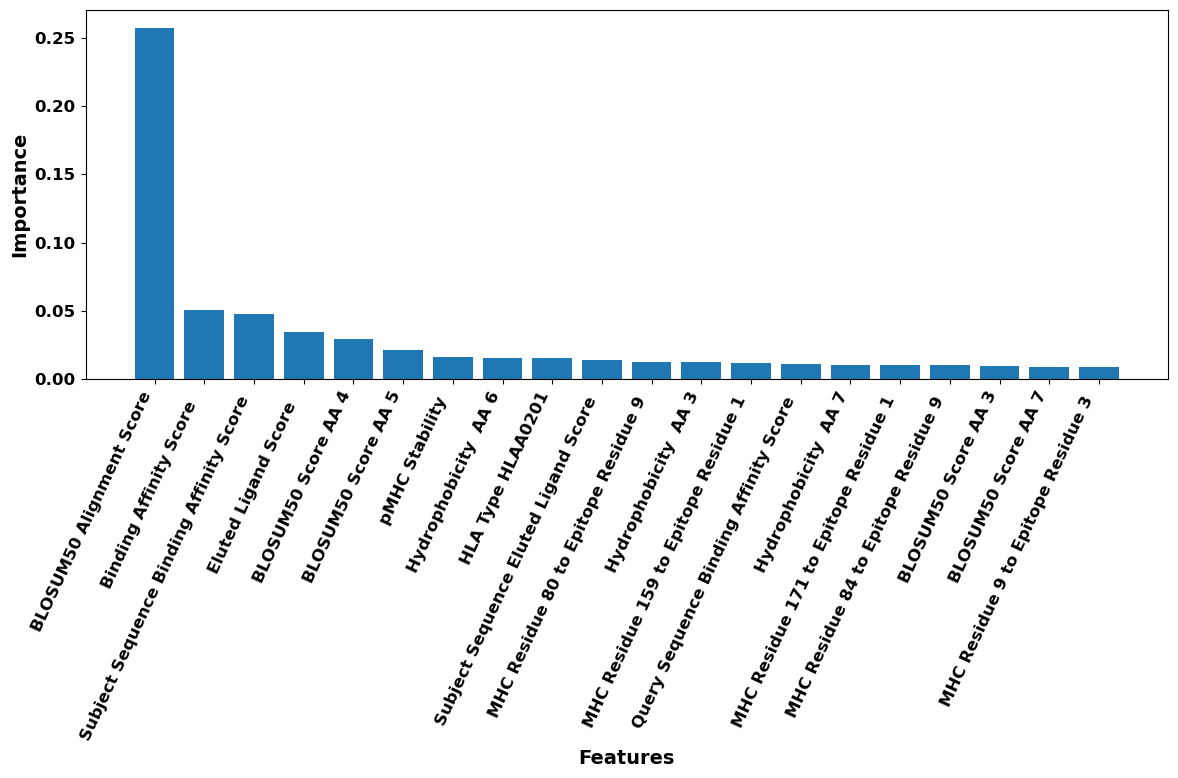

In [106]:
# Set global parameters for font
plt.rcParams['font.size'] = 14       # Adjust to change the size of all text
plt.rcParams['font.weight'] = 'bold' # Makes all text bold
plt.rcParams['axes.labelweight'] = 'bold' # Specifically makes axis labels bold
plt.rcParams['axes.titlesize'] = 16  # Adjust to change the size of titles
plt.rcParams['axes.titleweight'] = 'bold' # Specifically makes title bold
plt.rcParams['xtick.labelsize'] = 12 # Adjust to change the size of x-tick labels
plt.rcParams['ytick.labelsize'] = 12 # Adjust to change the size of y-tick labels

# Set the number of top features to display
N = 20

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['Feature'][:N], feature_importance_df['Importance'][:N])
plt.xticks(rotation=65, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')

# Adjust layout to prevent cut-off labels
plt.tight_layout()

# Show the plot
plt.show()

In [14]:
# Loop over each group, training on all but one group and testing on the left-out group
for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on training data
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Store the predictions in the corresponding test indices
    predicted_labels[test_index] = y_pred

# Add the predicted labels to the original dataframe
df['Predicted Label'] = predicted_labels.astype(int)

In [ ]:
df.to

In [15]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    if len(np.unique(y_true)) == 1:  # Only one class present
        return {
            'precision': np.nan,
            'recall': np.nan,
            'f1_score': np.nan,
            'accuracy': accuracy_score(y_true, y_pred)
        }
    return {
        'precision': precision_score(y_true, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='binary', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='binary', zero_division=0),
        'accuracy': accuracy_score(y_true, y_pred)
    }

In [16]:
# Overall metrics
overall_metrics = calculate_metrics(df['Label'], df['Predicted Label'])

# Metrics by Group ID
group_metrics = {}
for group_id, group_data in df.groupby('Group ID'):
    group_metrics[group_id] = calculate_metrics(group_data['Label'], group_data['Predicted Label'])

# Metrics by HLA Type
hla_type_metrics = {}
for hla_type in df.columns[df.columns.str.startswith('HLA Type_')]:
    hla_data = df[df[hla_type] == 1]  # Select data where this HLA type is present
    hla_type_metrics[hla_type] = calculate_metrics(hla_data['Label'], hla_data['Predicted Label'])

# Display results
print("Overall Metrics:", overall_metrics)
print("\nMetrics by Group ID:")
for group_id, metrics in group_metrics.items():
    print(f"Group {group_id}: {metrics}")

print("\nMetrics by HLA Type:")
for hla_type, metrics in hla_type_metrics.items():
    print(f"{hla_type}: {metrics}")

Overall Metrics: {'precision': 0.018313953488372094, 'recall': 0.26359832635983266, 'f1_score': 0.034248437075292196, 'accuracy': 0.30727237278221875}

Metrics by Group ID:
Group 1: {'precision': 0.22413793103448276, 'recall': 0.5, 'f1_score': 0.30952380952380953, 'accuracy': 0.5166666666666667}
Group 2: {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'accuracy': 0.16666666666666666}
Group 3: {'precision': nan, 'recall': nan, 'f1_score': nan, 'accuracy': 0.3333333333333333}
Group 4: {'precision': 0.7142857142857143, 'recall': 0.6818181818181818, 'f1_score': 0.6976744186046512, 'accuracy': 0.6578947368421053}
Group 5: {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'accuracy': 0.20833333333333334}
Group 6: {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0, 'accuracy': 0.625}
Group 7: {'precision': 0.0025041736227045075, 'recall': 0.5, 'f1_score': 0.0049833887043189366, 'accuracy': 0.2498434564809017}
Group 8: {'precision': nan, 'recall': nan, 'f1_score': nan, 'accuracy': 0.0}
Grou

In [28]:
final_df = pd.read_excel('features.xlsx')
final_df.drop('Unnamed: 0', axis=1, inplace=True)

In [29]:
final_df['Group ID'] = df['Group ID']
final_df['Predicted Label'] = df['Predicted Label']

In [31]:
final_df.to_excel('Predictions/XGboost.xlsx')

In [44]:
def run_logo_cv(df, models_params):
    logo = LeaveOneGroupOut()
    X = df.drop(['Label', 'Group ID'], axis=1)
    y = df['Label']
    groups = df['Group ID']
    
    results = {}
    
    for model_name, params in models_params.items():
        print(f"Processing {model_name} model...")
        predicted_labels = np.zeros(len(df))
        
        if model_name in ['nn', 'svm', 'lr', 'lrrf', 'lrxgb']:
            scaler = StandardScaler()
        
        for train_index, test_index in logo.split(X, y, groups):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            if model_name in ['nn', 'svm', 'lr', 'lrrf', 'lrxgb']:
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_train_scaled = X_train
                X_test_scaled = X_test
            
            if model_name == 'nn':
                inputs = Input(shape=(X_train_scaled.shape[1],))
                x = Dense(params['units1'], activation='relu')(inputs)
                x = Dropout(params['dropout1'])(x)
                x = Dense(params['units2'], activation='relu')(x)
                x = Dropout(params['dropout2'])(x)
                outputs = Dense(1, activation='sigmoid')(x)
                
                model = Model(inputs=inputs, outputs=outputs)
                model.compile(optimizer=Adam(learning_rate=params['lr']), loss='binary_crossentropy', metrics=['accuracy'])
                model.fit(X_train_scaled, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
                
                y_pred = (model.predict(X_test_scaled, batch_size=32) > 0.5).astype(int).flatten()
            elif model_name == 'lrrf':
                lr_params = {
                    'C': params['lr_C'],
                    'penalty': params['lr_penalty'],
                    'class_weight': params['lr_class_weight'],
                    'max_iter': params['lr_max_iter'],
                    'random_state': 42
                }

                if params['lr_penalty'] == 'l1':
                    lr_params['solver'] = params.get('solver_l1', 'saga')
                elif params['lr_penalty'] == 'l2':
                    lr_params['solver'] = params.get('solver_l2', 'lbfgs')
                elif params['lr_penalty'] == 'elasticnet':
                    lr_params['solver'] = 'saga'
                    lr_params['l1_ratio'] = params['lr_l1_ratio']
                else:
                    lr_params['solver'] = params.get('solver_none', 'lbfgs')

                lr = LogisticRegression(**lr_params)
                rf = RandomForestClassifier(n_estimators=params['rf_n_estimators'], max_depth=params['rf_max_depth'],
                                            min_samples_split=params['rf_min_samples_split'], 
                                            min_samples_leaf=params['rf_min_samples_leaf'],
                                            max_features=params['rf_max_features'], class_weight=params['rf_class_weight'],
                                            bootstrap=params['rf_bootstrap'], criterion=params['rf_criterion'],
                                            min_impurity_decrease=params['rf_min_impurity_decrease'], random_state=42)
                model = StackingClassifier([('lr', lr), ('rf', rf)], final_estimator=LogisticRegression())
                
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            elif model_name == 'lrxgb':
                lr_params = {
                    'C': params['lr_C'],
                    'penalty': params['lr_penalty'],
                    'class_weight': params['lr_class_weight'],
                    'max_iter': params['lr_max_iter'],
                    'random_state': 42
                }

                if params['lr_penalty'] == 'l1':
                    lr_params['solver'] = params.get('solver_l1', 'saga')
                elif params['lr_penalty'] == 'l2':
                    lr_params['solver'] = params.get('solver_l2', 'lbfgs')
                elif params['lr_penalty'] == 'elasticnet':
                    lr_params['solver'] = 'saga'
                    lr_params['l1_ratio'] = params['lr_l1_ratio']
                else:
                    lr_params['solver'] = params.get('solver_none', 'lbfgs')

                lr = LogisticRegression(**lr_params)
                xgb = XGBClassifier(**{k: v for k, v in params.items() if not k.startswith('lr_')}, 
                                    random_state=42, use_label_encoder=False, eval_metric='logloss')
                model = StackingClassifier([('lr', lr), ('xgb', xgb)], final_estimator=LogisticRegression())
                
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                if model_name == 'xgb':
                    model = XGBClassifier(**params, random_state=42, use_label_encoder=False, eval_metric='logloss')
                elif model_name == 'rf':
                    model = RandomForestClassifier(**params, random_state=42)
                elif model_name == 'svm':
                    model = SVC(**params, random_state=42)
                elif model_name == 'lr':
                    lr_params = {
                        'C': params['C'],
                        'penalty': params['penalty'],
                        'class_weight': params['class_weight'],
                        'max_iter': params['max_iter'],
                        'random_state': 42
                    }

                    if params['penalty'] == 'l1':
                        lr_params['solver'] = params.get('solver_l1', 'saga')
                    elif params['penalty'] == 'l2':
                        lr_params['solver'] = params.get('solver_l2', 'lbfgs')
                    elif params['penalty'] == 'elasticnet':
                        lr_params['solver'] = 'saga'
                        lr_params['l1_ratio'] = params['l1_ratio']
                    else:
                        lr_params['solver'] = params.get('solver_none', 'lbfgs')

                    model = LogisticRegression(**lr_params)
                
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            
            predicted_labels[test_index] = y_pred
        
        new_df = df.copy()
        new_df['Predicted Label'] = predicted_labels.astype(int)
        results[f'df_{model_name}_dl'] = new_df
    
    return results

# Create a dictionary with all model parameters
models_params = {
    'xgb': xgb_params_dl,
    'nn': nn_params_dl,
    'rf': rf_params_dl,
    'svm': svm_params_dl,
    'lr': lr_params_dl,
    'lrrf': lrrf_params_dl,
    'lrxgb': lrxgb_params_dl
}

# Run the function
results = run_logo_cv(df, models_params)

# Access individual dataframes
df_xgb_dl = results['df_xgb_dl']
df_nn_dl = results['df_nn_dl']
df_rf_dl = results['df_rf_dl']
df_svm_dl = results['df_svm_dl']
df_lr_dl = results['df_lr_dl']
df_lrrf_dl = results['df_lrrf_dl']
df_lrxgb_dl = results['df_lrxgb_dl']

Processing xgb model...
Processing nn model...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms

c:\Users\flo46\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flo46\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing lrxgb model...


c:\Users\flo46\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flo46\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flo46\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flo46\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\flo46\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [51]:
df_xgb_dl.to_excel('Predictions/XGB_dl_1.xlsx')

In [ ]:
df_xgb_dl = results['df_xgb_dl']
df_nn_dl = results['df_nn_dl']
df_rf_dl = results['df_rf_dl']
df_svm_dl = results['df_svm_dl']
df_lr_dl = results['df_lr_dl']
df_lrrf_dl = results['df_lrrf_dl']
df_lrxgb_dl = results['df_lrxgb_dl']